HW solutions. Primarily prepared by Sidhika Balachandar. 

In [1]:
import stan

import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [2]:
import warnings
warnings.filterwarnings('once')

In [3]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In this homework, you're going to go through an exercise in going from a problem description, to writing down a statistical model, to fitting it both using raw Python and in Stan

**Model**: We have two independent variables (covariates), $x1$ and $x2$, and two unknown latent parameters $\alpha$ and $\beta$. The independent data $y$ is generated as follows. First, a coin is flipped and if it is heads, then $y = 0$. Otherwise, $y$ is drawn according to a Poisson random variable. This is typically called a "zero-inflated Poisson" model. 

The coin flip is heads with probability $logit^{-1}(\alpha x_1)$. The Poisson random variable has rate $e^{\beta x_2}$. 

Our prior is that $\alpha, \beta$ are both drawn from a uniform random variable between -1 and 1. The covariates are both drawn from a Normal distribution with mean 0 and variance 1. 

# Conceptual: Describe a research setting that conceivably corresponds to this data generating process 

A research setting that corresponds to a zero-inflated Poisson model is predicting the how many times individuals in a city visit the ER in a given year. Many individuals will never visit the ER because they are healthy which represents the "zero-inflation". The poisson model will account for the other individuals who visit the ER at least once. 

# Write the statistical model down in math.
In other words, what are the distributions from which $x_1, x_2, \alpha, \beta, y$ are sampled?

Either using LaTeX within markdown, or inserting an image with math into the markdown. 

$x_1\sim \textrm{Normal}(0,1)$

$x_2\sim \textrm{Normal}(0,1)$

$\alpha\sim \textrm{Uniform}(-1,1)$

$\beta\sim \textrm{Uniform}(-1,1)$

$y \sim Bernoulli(1 - logit^{-1}(\alpha*x_1))\times Poisson(e^{\beta*x_2})$

# Generate data from the true model, given fixed parameters $\alpha, \beta$

In [5]:
from scipy import stats
from scipy.stats import bernoulli, norm, poisson

def inv_logit(v):
    return 1/(1+np.exp(-v))

# the output should be a dataframe with columns x1, x2, y
def generate_data(theta, N):
    alpha, beta = theta #as in lecture, theta = (alpha, beta)
    x1 = norm.rvs(size=N)
    x2 = norm.rvs(size=N)
    # in bernoulli output 1 = head, 0 = tail
    C = bernoulli.rvs(inv_logit(alpha * x1), size=N)
    # now 1 = tail, 0 = head
    C = np.logical_not(C)
    poi = poisson.rvs(np.exp(beta * x2), size=N)
    # poisson draw is kept for tail, 0 for head
    y = C * poi
    data = {'x1':x1, 'x2':x2, 'y':y}
    d = pd.DataFrame.from_dict(data)
    return d

In [6]:
def plot_generated_data(df):
    sns.histplot(df.y)
    plt.yscale('log')
    plt.show()
    
    cuts = pd.DataFrame({str(feature) + 'Bin' : pd.qcut(df[feature], 5) for feature in ['x1', 'x2']})
    dfplot = pd.concat([df, cuts], axis=1)[['y', 'x1Bin', 'x2Bin']].groupby(['x1Bin', 'x2Bin']).mean().reset_index()
    dfpivot = dfplot.pivot(index='x1Bin', columns='x2Bin', values='y')
    plt.clf()
    sns.heatmap(dfpivot) 
    plt.title('Means of y vs Features x1 and x2')
    plt.tight_layout()
    plt.show()

The below will plot the data once you have filled out the above function

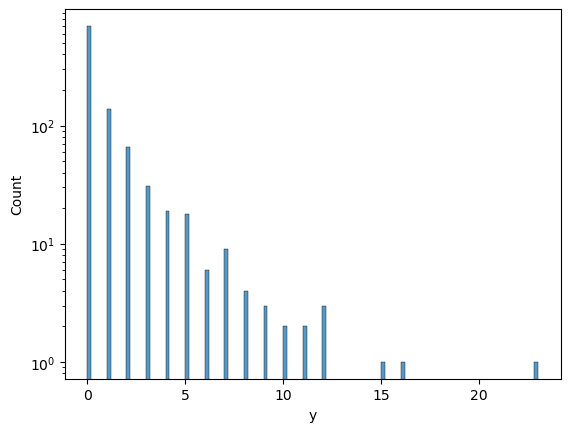

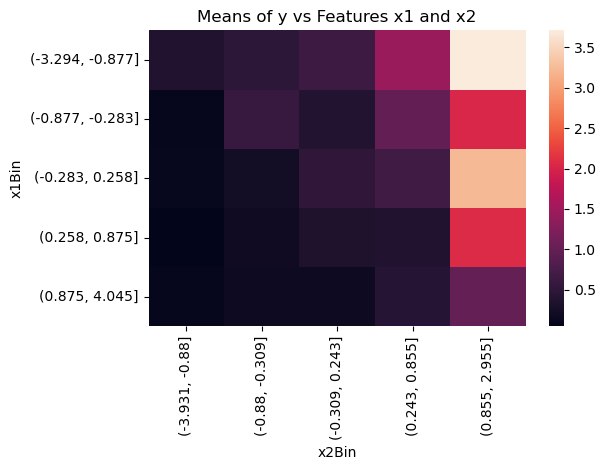

In [7]:
alpha, beta = (1, 1)
df = generate_data((alpha, beta), 1000)
plot_generated_data(df)

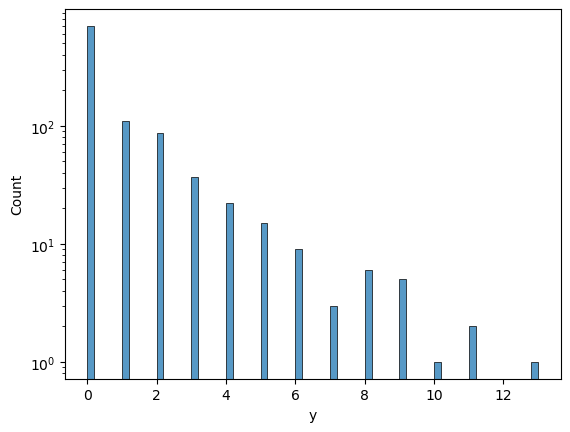

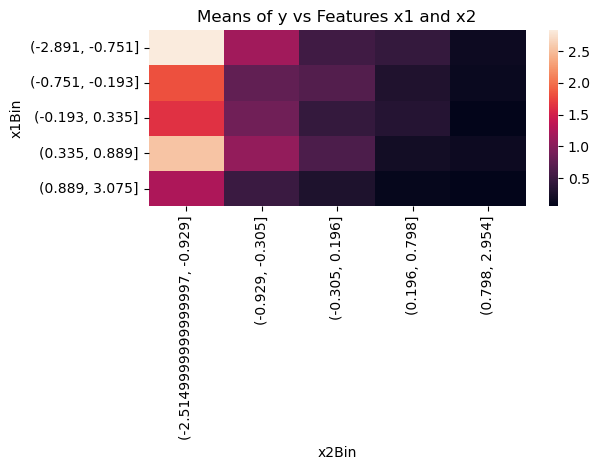

In [8]:
alpha, beta = (.5, -1)
df = generate_data((alpha, beta), 1000)
plot_generated_data(df)

# Calculate posterior using your own code

As we did in Lecture 2 and Lecture 4

In [9]:
# Prior for alpha, beta from the statistical model

#TODO finish this function for the pdf of theta. Hint: what is the area of the rectangle from -1 to 1 in both dimensions?
def p_theta(theta):
    alpha, beta = theta
    if alpha > 1 or alpha < -1 or beta > 1 or beta < -1:
        return 0
    else:
        return 1/4.0

In [10]:
from scipy.stats import norm

# TODO finish this function for P({y} | theta, {x1}, {x2})
# Bonus: do this in log space to avoid underflow
def p_data_given_theta(theta, data, do_log = False):
    alpha, beta = theta
    ys = data['y']
    
    #TODO finish this function for P(y | theta, x1, x2)
    # Hint: there are 2 cases, y_i = 0 and y_i > 0
    # Hint: you'll use the inv_logit function defined above
    # Hint: you'll use the poisson distribution from scipy.stats, and the pmf method of the poisson distribution
    def single_y_likelihood(y, x1, x2):
        logit_prob = inv_logit(alpha * x1)
        if y == 0:
            return logit_prob + (1 - logit_prob) * poisson.pmf(y, np.exp(beta * x2))
        elif y > 0:
            return (1 - logit_prob) * poisson.pmf(y, np.exp(beta * x2))
        else:
            return 0
    
    vals = [single_y_likelihood(y, x1, x2) for y, x1, x2 in zip(ys, data['x1'], data['x2'])]
    data['vals'] = vals
    
    # TODO finish below
    if not do_log:
        # maybe consider adding epsilon before taking log
        # return np.exp(np.sum(np.log(vals)))
        return np.product(vals)
    else:
        return np.sum(np.log(vals))

# TODO finish this function for P(y | x1, x2)
# bonus: do this in log space to avoid underflow
def p_data(data, possible_theta_values, do_log = False):
    """
    This function is the marginal likelihood of the data.
    It is the integral of the likelihood function over possible values of theta, weighted by the prior.
    """
    # def correct_p(theta):
    #     p_theta(theta)/np.sum([p_theta(theta) for theta in possible_theta_values])
    
    vals = [p_data_given_theta(theta, data) * p_theta(theta) for theta in possible_theta_values]
    unweighted_integral = np.sum(vals)

    if not do_log:

        integral = unweighted_integral / np.sum([p_theta(theta) for theta in possible_theta_values])
        return integral
    else:
        unweighted_integral = np.log(np.sum(vals))
        denom_weight = np.log(np.sum([p_theta(theta) for theta in possible_theta_values]))
        return unweighted_integral - denom_weight

Grid sampling

In [20]:
# TODO finish this function to sample possible_theta_values, p_theta_given_data using grid sampling
# bonus: do this in log space to avoid underflow
def grid_sampling(data, gridnum = 1000, do_log = False):
    possible_alpha_values = np.linspace(-1, 1, gridnum)
    possible_beta_values = np.linspace(-1, 1, gridnum)
    possible_theta_values = [(alpha, beta) for alpha in possible_alpha_values for beta in possible_beta_values]


    denominator = p_data(data, possible_theta_values, do_log = do_log)

    #TODO finish 
    if not do_log:
        p_theta_given_data = [p_data_given_theta(theta, data) * p_theta(theta) / denominator 
                            for theta in possible_theta_values]
        return possible_theta_values, p_theta_given_data
    else:
        p_theta_given_data = [p_data_given_theta(theta, data, do_log=True) 
                              + np.log(p_theta(theta)) - denominator
                            for theta in possible_theta_values]
        return possible_theta_values, p_theta_given_data

In [21]:
true_alpha, true_beta = (.25, .5)
df = generate_data((true_alpha, true_beta), 100)

Below will plot posterior for alpha, beta using grid sampling

/tmp/ipykernel_15305/1084922637.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(dfplot.pivot('alpha', 'beta', 'p_theta_given_data'))


<AxesSubplot: xlabel='beta', ylabel='alpha'>

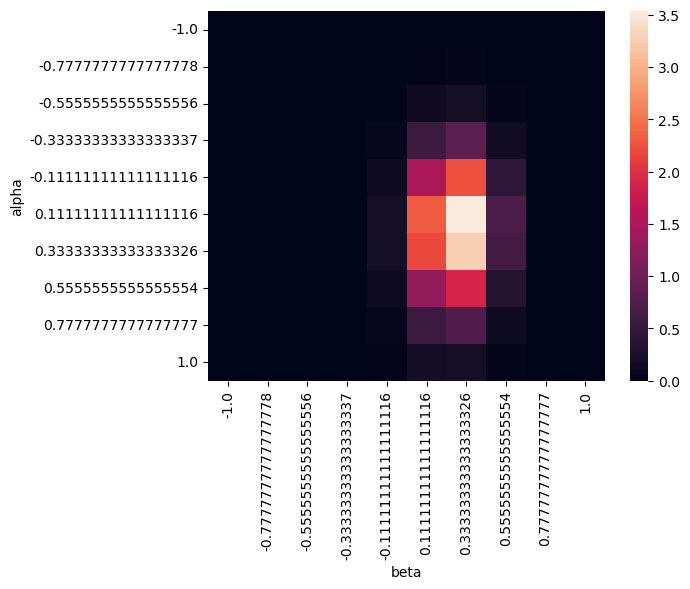

In [22]:
possible_theta_values, p_theta_given_data = grid_sampling(df, gridnum = 10)
dfplot = pd.DataFrame(possible_theta_values, columns=['alpha', 'beta'])
dfplot['p_theta_given_data'] = p_theta_given_data
from matplotlib.colors import LogNorm, Normalize
sns.heatmap(dfplot.pivot('alpha', 'beta', 'p_theta_given_data'))

Bonus: Below will plot log posterior for alpha, beta using grid sampling in log space.

/tmp/ipykernel_15305/2599288042.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))


Text(0.5, 1.0, 'log_p_theta_given_data')

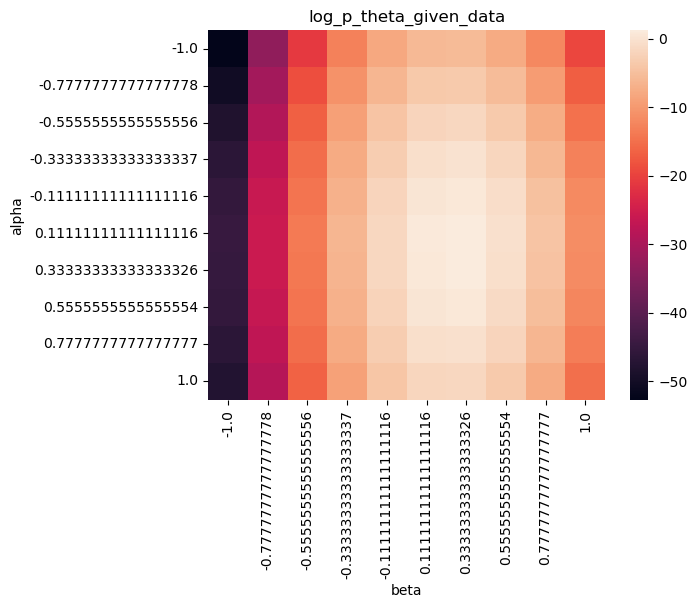

In [23]:
possible_theta_values, p_theta_given_data = grid_sampling(df, gridnum = 10, do_log=True)
dfplot = pd.DataFrame(possible_theta_values, columns=['alpha', 'beta'])
dfplot['log_p_theta_given_data'] = p_theta_given_data
sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))
plt.title('log_p_theta_given_data')

In log space, can do with larger datasets without underflow (though P(data) is still troublesome...)

/tmp/ipykernel_15305/3981045437.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))


Text(0.5, 1.0, 'log_p_theta_given_data')

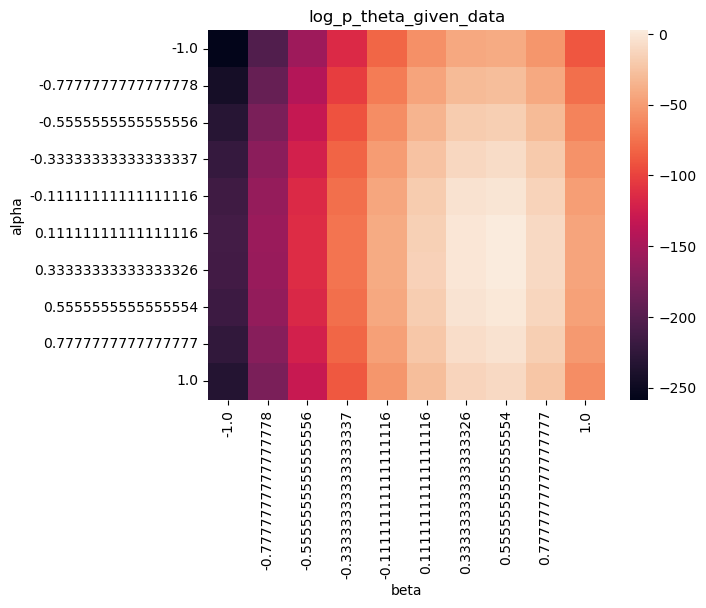

In [24]:
true_alpha, true_beta = (.25, .5)
df = generate_data((true_alpha, true_beta), 500)
possible_theta_values, p_theta_given_data = grid_sampling(df, gridnum = 10, do_log=True)
dfplot = pd.DataFrame(possible_theta_values, columns=['alpha', 'beta'])
dfplot['log_p_theta_given_data'] = p_theta_given_data
sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))
plt.title('log_p_theta_given_data')

With more data points, we get much tighter posteriors (observe the color scale)

# Now, fit a Stan model for this dataset

In [108]:
true_alpha, true_beta = (.25, .5)
df = generate_data((true_alpha, true_beta), 2000)

## First, just fit a Poisson regression, ignoring the zero inflation

First, we'll fit a "mis-specified" model -- suppose we just fit a Poisson regression, i.e.:

\begin{align*}
    y &\sim Poisson (e^{intercept + \alpha*x_1 + \beta*x_2})
\end{align*}
The following will be useful: https://mc-stan.org/docs/functions-reference/poisson-log-glm.html. You'll likely need to directly increment the `target` parameter. 

In [109]:
stan_data = {'N': df.shape[0], 'y': df.y.values, 'X': df[['x1', 'x2']].values}

TODO: write a Stan model and save it in poissonregression.stan

In [110]:
stan_folder = './'
stan_file = stan_folder + 'poissonregression.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Stan code to fit normal distribution with improper prior

data {
  int<lower=0> N;
  int<lower=0> y[N];
  matrix[N,2] X;
}
parameters {
  real intercept;
  vector[2] alpha_beta;

}
model {
  intercept ~ normal(0, 2);
  alpha_beta ~ uniform(-1, 1);
  target += poisson_log_glm_lpmf(y | X, intercept, alpha_beta);
}

generated quantities {
  # posterior predictive distribution 

  array[N] int yposterior_pred;
  for (i in 1:N)
    yposterior_pred[i] = poisson_log_rng(intercept + dot_product(X[i], alpha_beta));
}


In [111]:
compiled_model = stan.build(model_code, data=stan_data)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_kuqu_619/model_c6plcxmp.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_kuqu_619/model_c6plcxmp.stan', line 20, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_kuqu_619/model_c6plcxmp.stan', line 15, column 2: Parameter
    alpha_beta is given a uniform distribution. The uniform distribution is
    not recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified

In [112]:
# num warmup = 250 gets rid of warning
fit = compiled_model.sample(num_chains=2, num_warmup = 250, num_samples= 500)

Sampling:   0%
Sampling:   7% (100/1500)
Sampling:  13% (200/1500)
Sampling:  57% (850/1500)
Sampling: 100% (1500/1500)
Sampling: 100% (1500/1500), done.
Messages received during sampling:
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. neg

We wrote some of the code for you to analyze the model fit

In [113]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model, posterior_predictive=['yposterior_pred'], observed_data=['y'])

In [114]:
summary = az.summary(fit, var_names = ['intercept', 'alpha_beta'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.681,0.033,-0.748,-0.624,0.001,0.001,774.0,634.0,1.0
alpha_beta[0],-0.097,0.029,-0.152,-0.043,0.001,0.001,746.0,750.0,1.0
alpha_beta[1],0.501,0.031,0.449,0.564,0.001,0.001,662.0,645.0,1.0


array([<AxesSubplot: title={'center': 'intercept'}>,
       <AxesSubplot: title={'center': 'alpha_beta\n0'}>,
       <AxesSubplot: title={'center': 'alpha_beta\n1'}>], dtype=object)

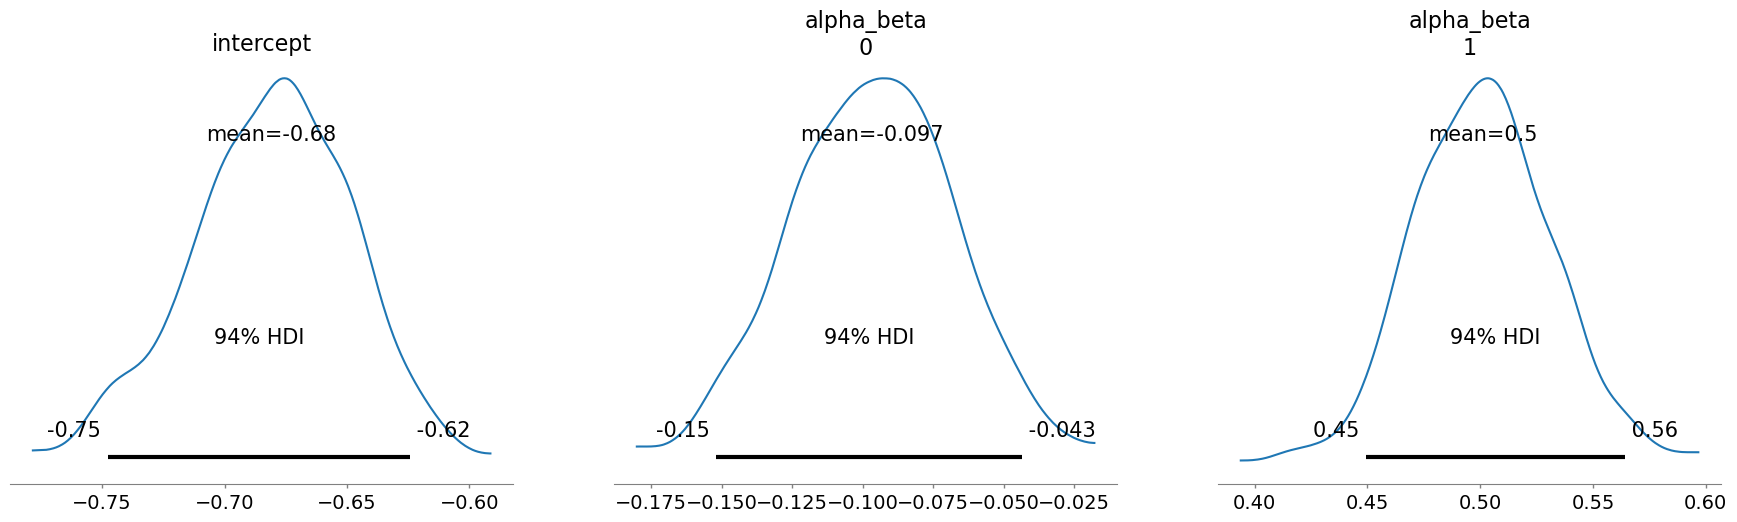

In [115]:
az.plot_posterior(idata)

array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'alpha_beta\n0'}>,
        <AxesSubplot: title={'center': 'alpha_beta\n0'}>],
       [<AxesSubplot: title={'center': 'alpha_beta\n1'}>,
        <AxesSubplot: title={'center': 'alpha_beta\n1'}>]], dtype=object)

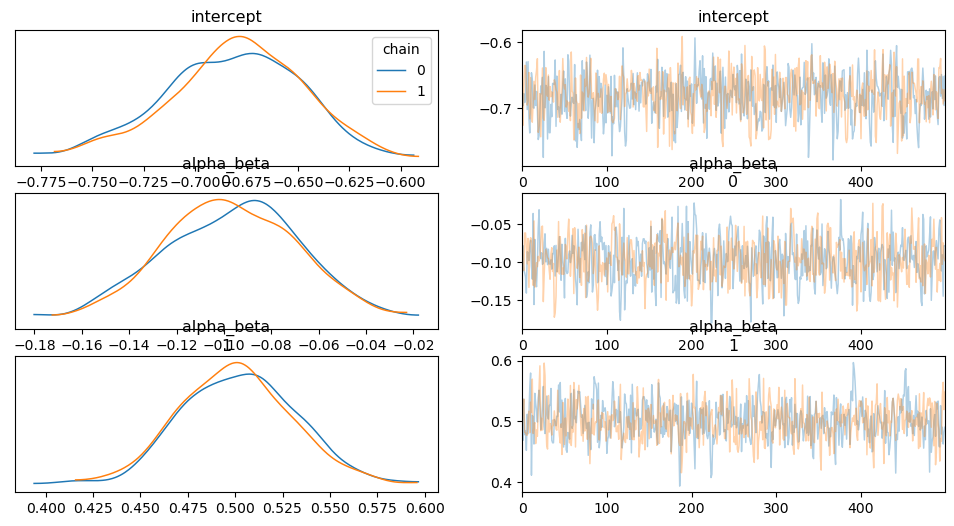

In [116]:
az.plot_trace(fit, compact=False, legend=True, var_names=['~yposterior_pred'])

array([[<AxesSubplot: ylabel='alpha_beta\n0'>, <AxesSubplot: >],
       [<AxesSubplot: xlabel='intercept', ylabel='alpha_beta\n1'>,
        <AxesSubplot: xlabel='alpha_beta\n0'>]], dtype=object)

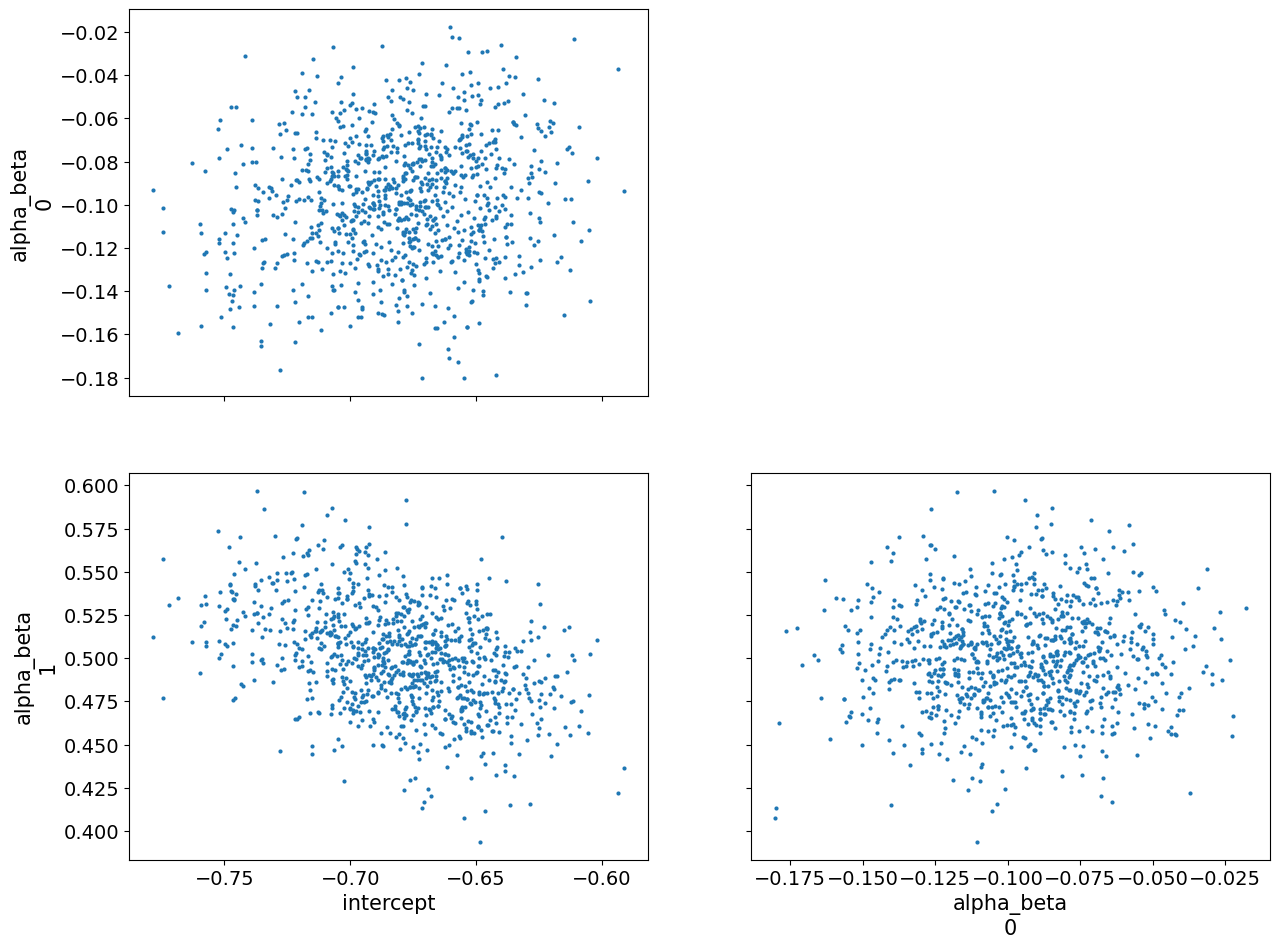

In [117]:
az.plot_pair(idata)

In [118]:
# TODO: In your poissonregression.stan file, use the generated quantities block to sample 
# from the posterior predictive distribution and plot the posterior predictive distribution here.
# Display it in the same plot as the true $y$ data, and comment on comparing the two.

In [119]:
pred_y_vals = [int(x) for x in idata.posterior_predictive.yposterior_pred.values.flatten()]
true_y_vals = df.y.values
max_y = int(max(max(pred_y_vals), max(true_y_vals)))
max_y

10

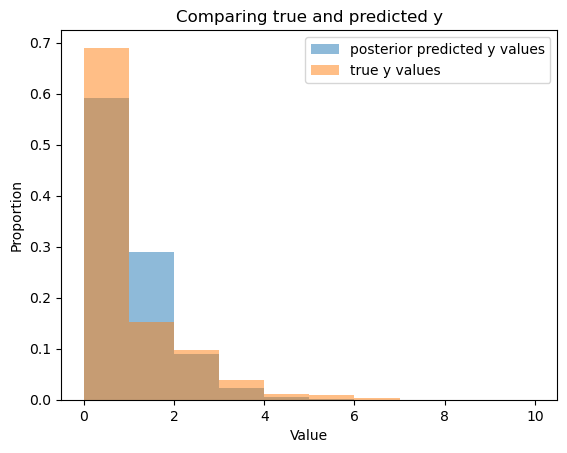

In [120]:
plt.hist(pred_y_vals, alpha=0.5, bins=int(max(pred_y_vals)), label='posterior predicted y values', density=True)
plt.hist(true_y_vals, alpha=0.5, bins=int(max(true_y_vals)), label='true y values', density=True)
plt.legend()
plt.title('Comparing true and predicted y')
plt.xlabel('Value')
plt.ylabel('Proportion')
# plt.yscale('log')
plt.show()

The main differences are that the model's posterior 1) generate too few values of 0 and 2) generates too many values of 1. This occurs because we are fitting a poisson model to data with an excess of zeros (zero-inflated poisson data). Therefore a standard poisson model of the same parameters will generate too few 0 values. We can change the parameters to genrate more 0 values, however this model will also produce too many 1 values. Thus we see a tradeoff between predicting too few 0 values and too many values above 0.

In [121]:
# TODO bonus: use arviz to plot the posterior predictive distribution

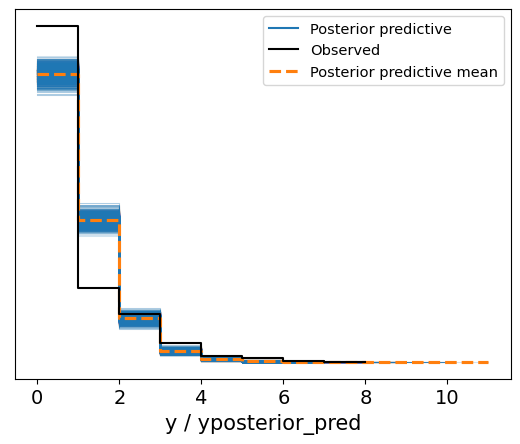

In [122]:
az.plot_ppc(idata, data_pairs = {'y': 'yposterior_pred'})
plt.show()

## Now, fit a correct Stan model reflecting the true data generating process

Now, fit a zero inflated Poisson in stan.

Hint: you'll need to directly increment the `target` parameter.

Hint: you'll likely need the following functions: `log_sum_exp`, `bernoulli_logit_lpmf`, `poisson_log_glm_lpmf`

Hint: I had to play around a bit with the input parameter formatting (e.g., put x2 inside its own matrix)

In [123]:
stan_data = {'N': df.shape[0], 'y': df.y.values, 'X1': df['x1'].values, 'X2': df['x2'].values}

In [124]:
stan_folder = './'
stan_file = stan_folder + 'zeroinflatedpoisson.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Stan code to fit normal distribution with improper prior

data {
  int<lower=0> N;
  array[N] int<lower=0> y;
  array[N] real X1;
  array[N] real X2;
}
parameters {
  real<lower=-1, upper=1> alpha;
  real<lower=-1, upper=1> beta;
}
model {
  for (i in 1:N) {
    if (y[i] == 0) {
      target += log_sum_exp(bernoulli_logit_lpmf(1 | alpha * X1[i]),
      bernoulli_logit_lpmf(0 | alpha * X1[i]) + poisson_lpmf(y[i] | exp(X2[i] * beta)));
    }
    else {
      target += bernoulli_logit_lpmf(0 | alpha * X1[i]) + poisson_lpmf(y[i] | exp(X2[i] * beta));
    } 
  }
}

generated quantities { 
  // //For posterior predictive check 
    array[N] int yposterior_pred;
    array[N] int<lower=0> coin_flips;
    for (i in 1:N) {
      coin_flips[i] = bernoulli_logit_rng(alpha * X1[i]);
      if (coin_flips[i] == 0) {
        yposterior_pred[i] = poisson_rng(exp(X2[i] * beta));
      } 
      else {
        yposterior_pred[i] = 0;
      }
  }
} 



In [125]:
compiled_model = stan.build(model_code, data=stan_data)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [126]:
fit = compiled_model.sample(num_chains=2, num_warmup = 250, num_samples= 500)

Sampling:   0%
Sampling:   0% (1/1500)
Sampling:   0% (2/1500)
Sampling:   7% (101/1500)
Sampling:  13% (200/1500)
Sampling:  20% (300/1500)
Sampling:  50% (750/1500)
Sampling:  60% (901/1500)
Sampling:  67% (1001/1500)
Sampling:  73% (1100/1500)
Sampling:  80% (1200/1500)
Sampling:  87% (1300/1500)
Sampling:  93% (1400/1500)
Sampling: 100% (1500/1500)
Sampling: 100% (1500/1500), done.
Messages received during sampling:
  Gradient evaluation took 0.004227 seconds
  1000 transitions using 10 leapfrog steps per transition would take 42.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00317 seconds
  1000 transitions using 10 leapfrog steps per transition would take 31.7 seconds.
  Adjust your expectations accordingly!


In [127]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model, posterior_predictive=['yposterior_pred'], observed_data=['y'])

In [128]:
summary = az.summary(fit, var_names = ['alpha', 'beta'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.204,0.064,0.072,0.311,0.002,0.002,900.0,681.0,1.00
beta,0.515,0.034,0.461,0.590,0.001,0.001,672.0,432.0,1.02


array([<AxesSubplot: title={'center': 'alpha'}>,
       <AxesSubplot: title={'center': 'beta'}>], dtype=object)

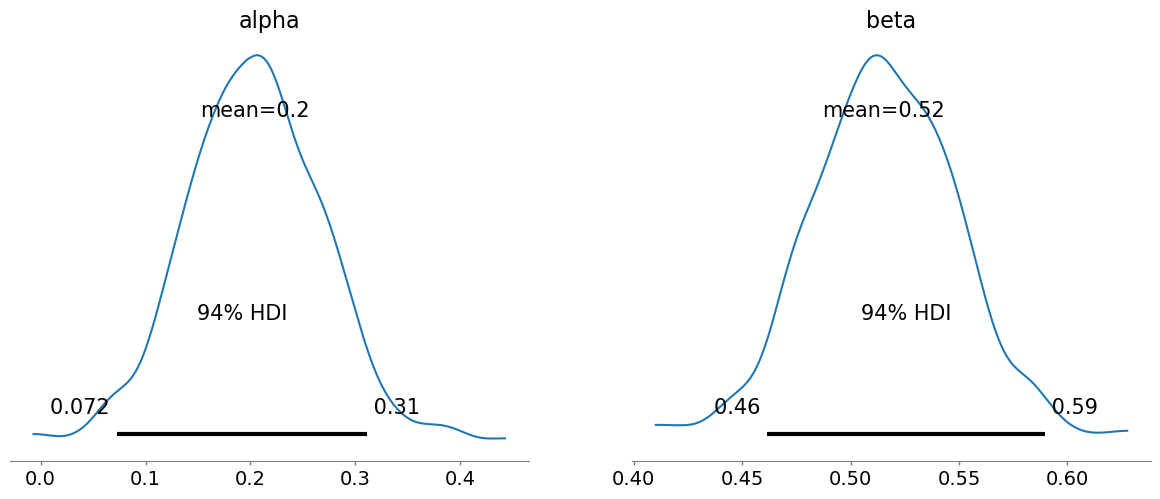

In [129]:
az.plot_posterior(idata, var_names = ['alpha', 'beta'])

array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>]], dtype=object)

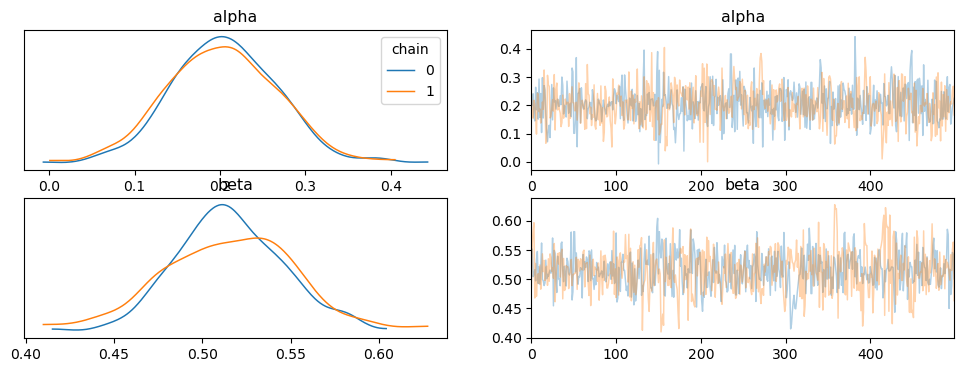

In [130]:
az.plot_trace(fit, compact=False, legend=True, var_names = ['alpha', 'beta'])

<AxesSubplot: xlabel='alpha', ylabel='beta'>

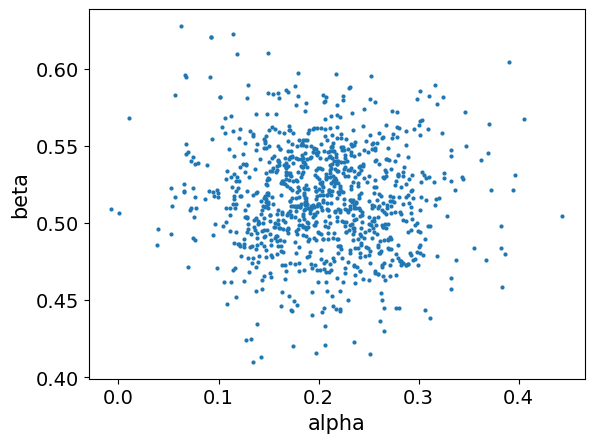

In [131]:
az.plot_pair(idata, var_names = ['alpha', 'beta'])

In [132]:
# TODO: As before, In your stan file, use the generated quantities block to sample 
# from the posterior predictive distribution and plot the posterior predictive distribution here.
# Display it in the same plot as the true $y$ data, and comment on comparing the two.

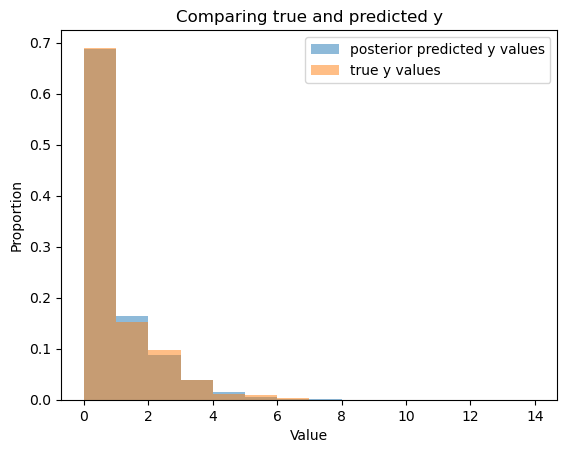

In [133]:
pred_y_vals = idata.posterior_predictive.yposterior_pred.values.flatten()
true_y_vals = df.y.values
plt.hist(pred_y_vals, alpha=0.5, bins=pred_y_vals.max(), label='posterior predicted y values', density=True)
plt.hist(true_y_vals, alpha=0.5, bins=true_y_vals.max(), label='true y values', density=True)
plt.legend()
plt.title('Comparing true and predicted y')
plt.xlabel('Value')
plt.ylabel('Proportion')
plt.show()

These two distribbutions look very similar. There are slight differences in the frequency of 0 and 1 values produced, however it is likely that with more sampling iterations these differences will also vanish.

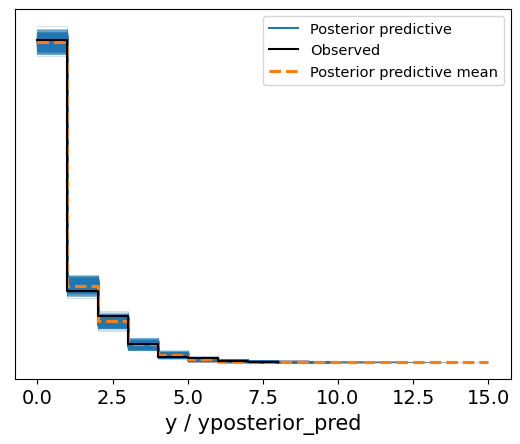

In [134]:
az.plot_ppc(idata, data_pairs = {'y': 'yposterior_pred'})
plt.show()